Mahendran Jinachandran - 24088951

Pushpak Raj Senthil Kumaran - 24128937

---

This CNN project runs till the end without any errors

---

**References**:

*   https://www.kaggle.com/code/ahmadjaved097/multiclass-image-classification-using-cnn/notebook
*   https://discuss.pytorch.org/t/understanding-transform-normalize/21730/15
* https://www.kaggle.com/code/shtrausslearning/pytorch-multiclass-image-classification



In [ ]:
import os
import torch
import time
import numpy as np
from torch import nn
import seaborn as sns
import torch.optim as optim
from tqdm.notebook import tqdm
from collections import Counter
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Subset
from torch.utils.data import DataLoader
from sklearn.model_selection import KFold
from torchvision import transforms, models
from sklearn.metrics import confusion_matrix
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
device = ("cuda" if torch.cuda.is_available() else "cpu" )
print(f"{device} device available")

cuda device available


## Data Fetching

In [ ]:
# Fetches data from GitHub
def fetch_data():
  !git clone https://github.com/mahendran-jinachandran/Multi-Class-Classification.git
  os.chdir('/content/Multi-Class-Classification') # Navigates to the dataset

In [ ]:
fetch_data()

Cloning into 'Multi-Class-Classification'...
remote: Enumerating objects: 17058, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 17058 (delta 0), reused 0 (delta 0), pack-reused 17057 (from 2)
Receiving objects: 100% (17058/17058), 380.06 MiB | 17.29 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (23976/23976), done.


## Constants

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = 150
TRAIN_DATA_PATH = "seg_train_full"
TEST_DATA_PATH = "seg_test_full"
MEAN = [0.485, 0.456, 0.406] # Standard values
STD = [0.229, 0.224, 0.225] # Standard values
EPOCHS = 10

## Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE , IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean = MEAN, std = STD)
])

train_dataset = ImageFolder(root = TRAIN_DATA_PATH ,transform = transform) # ImageFolder automatically gets the labels from the subfolder names
test_dataset = ImageFolder(root = TEST_DATA_PATH ,transform = transform)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE , shuffle = True) # Shuffling the dataset so that it is not biased
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE , shuffle = True) # Shuffling the dataset so that it is not biased

In [ ]:
# Labels present in the training dataset
labels = train_dataset.classes
print("Labels in the dataset: ")
for label in labels:
    print(label)

Labels in the dataset: 
buildings
forest
glacier
mountain
sea
street


## Visualisation

In [ ]:
images, labels_batch = next(iter(train_loader))

In [ ]:
# Used to unnormalise the images for display purposes
def unnormalize(image, mean, std):
    image = image.clone().cpu().numpy().transpose(1, 2, 0)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

# Used to display sample images
def plot_images(rows, columns, should_normalise, figure = (15,8)):
    _, ax = plt.subplots(rows, columns, figsize=figure)
    count = 0

    for i in range(rows):
        for j in range(columns):
            label = labels[labels_batch[count].item()]

            if should_normalise:
                img = unnormalize(images[count], MEAN, STD) # Used to display images normally without normalisation
            else:
                img = images[count].permute(1, 2, 0).numpy() # Used to display images with normalisation

            ax[i, j].imshow(img)
            ax[i, j].set_title(f"{label}")
            ax[i, j].axis("off")
            count += 1

    plt.tight_layout()
    plt.suptitle("Sample Training Images", fontsize=21)
    plt.show()

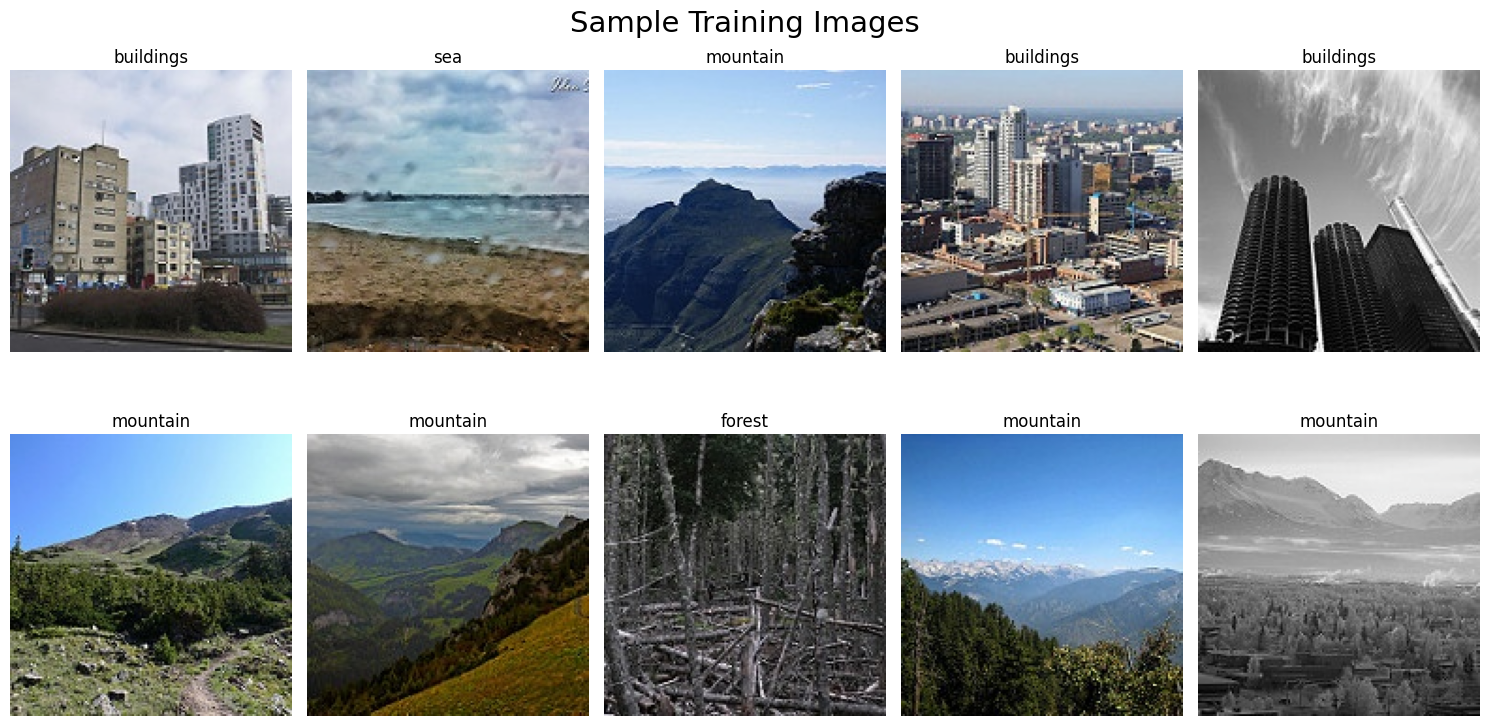

In [ ]:
# Display samples of unnormalised images for display purposes
plot_images(2, 5, True)

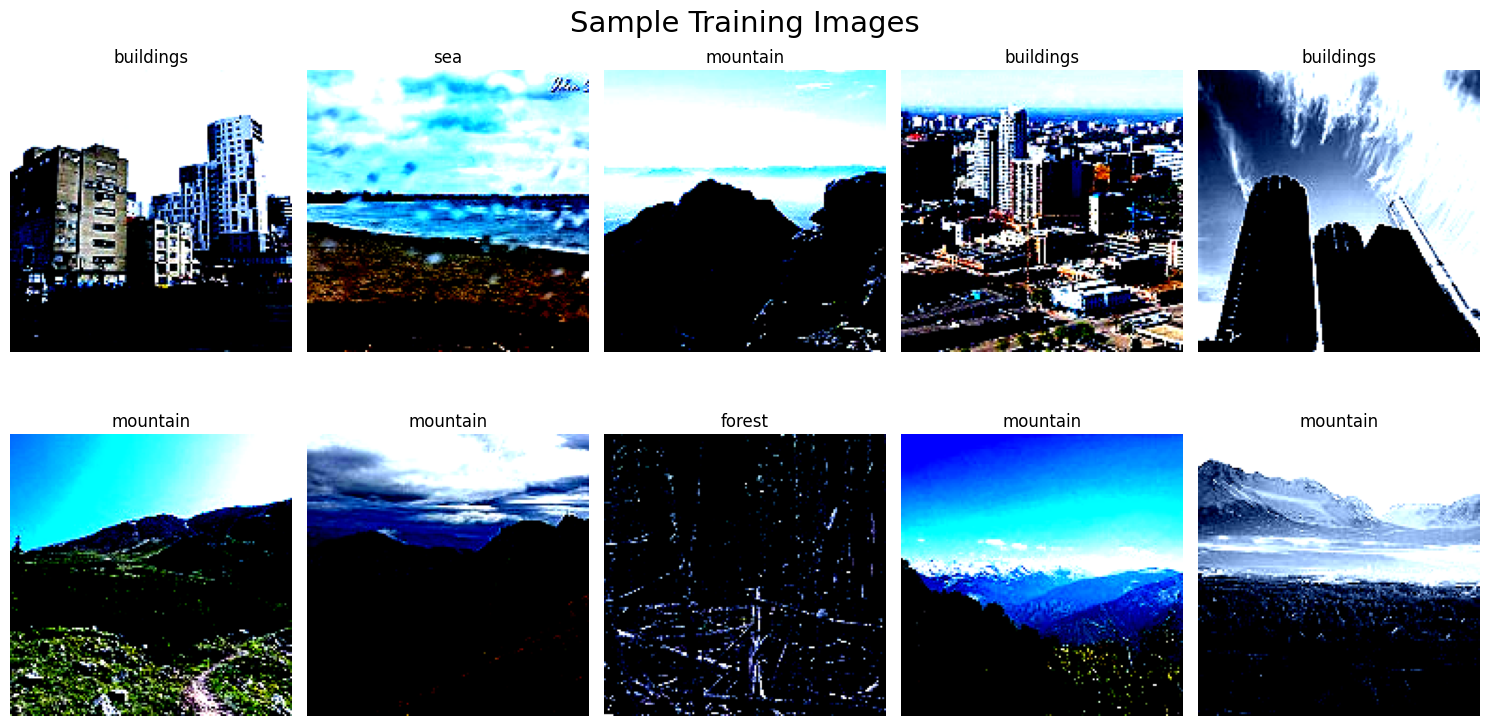

In [ ]:
# Display samples of normalised images which is fed into the model
plot_images(2, 5, False)

In [ ]:
# Fetches label for each instance present in the dataset
def get_labels(data_loader):
    labels = []
    for _, label in data_loader:
        labels.extend(label.numpy())

    return labels

In [ ]:
# Used to display number of samples belonging to each class
def display_bar_graph(data_loader, dataset_type):

    graph_labels = get_labels(data_loader)
    class_counts = Counter(graph_labels)
    counts = np.array([class_counts[i] for i in range(len(labels))])

    plt.figure(figsize=(10, 6))
    colors = plt.cm.Paired(np.linspace(0, 1, len(counts)))
    plt.bar(labels, counts, color=colors)
    plt.title(f'{dataset_type} - Class Distribution')
    plt.xlabel('Class / Category')
    plt.ylabel('Number of Samples per class')

    # Adjust layout
    plt.tight_layout()
    plt.show()

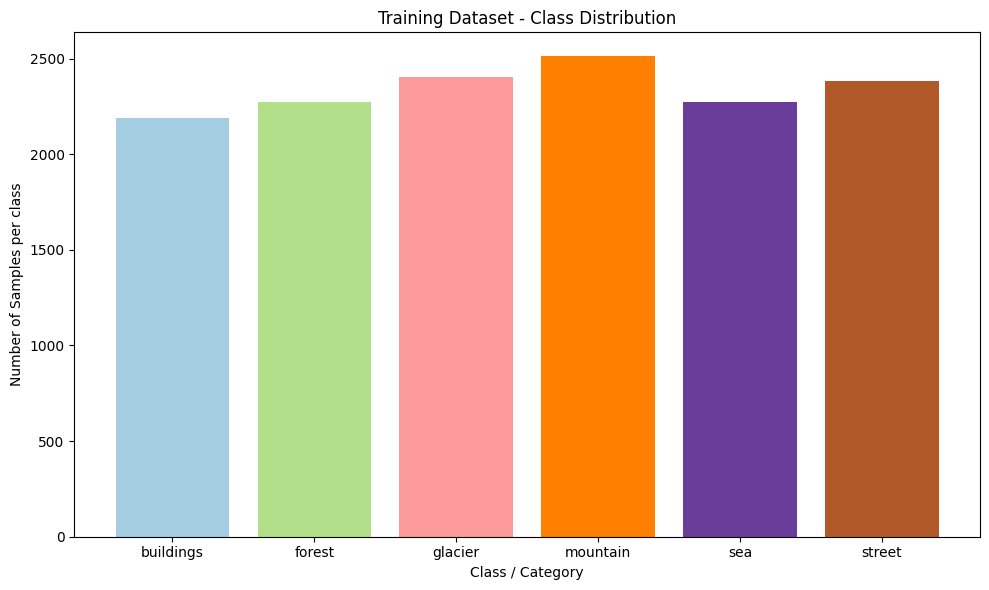

In [ ]:
# Displays the distribution in Training Data
display_bar_graph(train_loader, "Training Dataset")

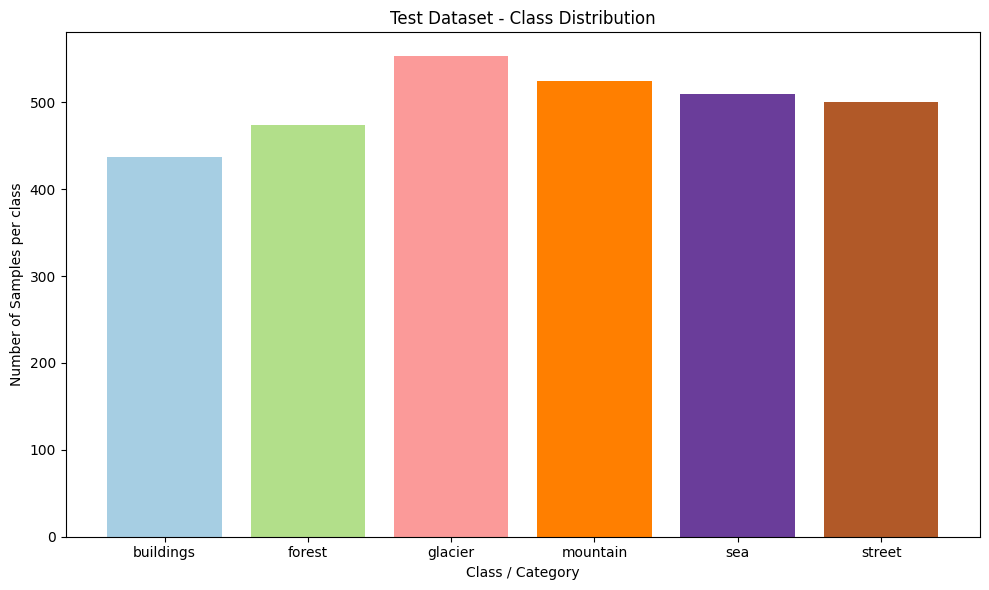

In [ ]:
# Displays the distribution in Test Data
display_bar_graph(test_loader, "Test Dataset")

## Building and Training Models

In [ ]:
def train(dataloader, model, loss_function, optimizer):
    size = len(dataloader.dataset)      # Size of the dataset
    model.train()                       # Switch to training mode

    for batch, (img , label) in enumerate(dataloader):
        img, label = img.to(device), label.to(device)
        pred = model(img)
        loss = loss_function(pred,label)
        optimizer.zero_grad()           # Resets the gradients
        loss.backward()                 # Calculates gradient via backpropogation
        optimizer.step()                # Updates the model parameters based on the gradients

        # prints the loss value only when the batch count is divisible by 50
        # to make the output neat and clear
        if batch % 50 == 0:
           loss, current = loss.item(), (batch + 1) * len(img)
           print(f"loss: {loss:.5f}  [{current}/{size}]")

def validate(dataloader, model, loss_fn):
    total_samples = len(dataloader.dataset)
    total_batches = len(dataloader)
    model.eval()                        # Switch to evaluation mode
    total_loss, accuracy = 0, 0

    with torch.no_grad():
        for img, label in dataloader:
            img, label = img.to(device), label.to(device)
            pred = model(img)
            total_loss += loss_fn(pred, label).item()
            correct_pred = (pred.argmax(dim=1) == label).sum().item()
            accuracy += float(correct_pred)

    total_loss /= total_batches
    accuracy /= total_samples
    return total_loss, accuracy

def build_model(train_dataloader, test_dataloader, model, loss_fn, optimizer, epochs, model_name):
    total_train_loss, total_train_accuracy = [], []
    total_test_loss, total_test_accuracy = [], []

    print(f"Training {model_name} model...")
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        print(f'Epoch {epoch + 1}/{epochs}')
        train(train_dataloader, model, loss_fn, optimizer)

        train_loss, train_acc = validate(train_dataloader, model, loss_fn)
        test_loss, test_acc = validate(test_dataloader, model, loss_fn)

        print(f"\nTrain Analysis: \n Accuracy: {(100*train_acc):.1f}%, Avg loss: {train_loss:.5f} \n")
        print(f"Test Analysis: \n Accuracy: {(100*test_acc):.1f}%, Avg loss: {test_loss:.5f} \n")

        total_train_loss.append(train_loss)
        total_train_accuracy.append(train_acc)
        total_test_loss.append(test_loss)
        total_test_accuracy.append(test_acc)

    end_time = time.time()
    total_time = end_time - start_time

    print(f"Training of the {model_name} model completed!")
    print(f"Total time taken: {total_time:.2f} seconds")
    return total_train_loss, total_train_accuracy, total_test_loss, total_test_accuracy

## CNN Architecture Model

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layers used to extract features
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5), # Using default stride (1) and padding (0)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3), # Using default stride (1) and padding (0)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3), # Using default stride (1) and padding (0)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
        )

        # Flattens the feature map
        self.flat = nn.Flatten()

        # Fully connected layer which predicts
        self.fc = nn.Sequential(
            nn.Linear(32*16*16, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 6)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.flat(x)
        x = self.fc(x)
        return x

cnn_model = CNNModel().to(device)

In [ ]:
summary(cnn_model, input_size=(3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 146, 146]           9,728
              ReLU-2        [-1, 128, 146, 146]               0
         MaxPool2d-3          [-1, 128, 73, 73]               0
       BatchNorm2d-4          [-1, 128, 73, 73]             256
            Conv2d-5           [-1, 64, 71, 71]          73,792
              ReLU-6           [-1, 64, 71, 71]               0
         MaxPool2d-7           [-1, 64, 35, 35]               0
       BatchNorm2d-8           [-1, 64, 35, 35]             128
            Conv2d-9           [-1, 32, 33, 33]          18,464
             ReLU-10           [-1, 32, 33, 33]               0
        MaxPool2d-11           [-1, 32, 16, 16]               0
      BatchNorm2d-12           [-1, 32, 16, 16]              64
          Flatten-13                 [-1, 8192]               0
           Linear-14                  [

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters() , lr = 0.001)
cnn_train_loss, cnn_train_accuracy, cnn_test_loss, cnn_test_accuracy = build_model(train_loader, test_loader, cnn_model, loss_function, optimizer, EPOCHS, "CNN")

Training CNN model...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
loss: 1.80697  [32/14034]
loss: 1.35974  [1632/14034]
loss: 1.40642  [3232/14034]
loss: 1.23725  [4832/14034]
loss: 0.55265  [6432/14034]
loss: 1.41382  [8032/14034]
loss: 0.80979  [9632/14034]
loss: 0.63554  [11232/14034]
loss: 0.80133  [12832/14034]

Train Analysis: 
 Accuracy: 77.6%, Avg loss: 0.63368 

Test Analysis: 
 Accuracy: 74.4%, Avg loss: 0.71005 

Epoch 2/10
loss: 0.75586  [32/14034]
loss: 0.83440  [1632/14034]
loss: 0.52133  [3232/14034]
loss: 0.45079  [4832/14034]
loss: 0.81325  [6432/14034]
loss: 0.42600  [8032/14034]
loss: 0.43495  [9632/14034]
loss: 0.58891  [11232/14034]
loss: 0.60186  [12832/14034]

Train Analysis: 
 Accuracy: 81.4%, Avg loss: 0.50241 

Test Analysis: 
 Accuracy: 78.0%, Avg loss: 0.63734 

Epoch 3/10
loss: 0.52757  [32/14034]
loss: 0.51918  [1632/14034]
loss: 0.28460  [3232/14034]
loss: 0.71031  [4832/14034]
loss: 0.52035  [6432/14034]
loss: 0.64496  [8032/14034]
loss: 0.20039  [9632/14034]
loss: 0.47350  [11232/14034]
loss: 0.54855  [1283

### Cross-Fold Validation

In [ ]:
def train_and_evaluate_on_fold(train_index, test_index, dataset, model, loss_fn, optimizer, device):

    train_subset = Subset(dataset, train_index)
    test_subset = Subset(dataset, test_index)

    train_loader = DataLoader(train_subset, batch_size = BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size = BATCH_SIZE, shuffle=False) # Set to `False` to ensure consistency and unbiased evaluation

    model = model.to(device)

    train(train_loader, model, loss_fn, optimizer)
    _, accuracy = validate(test_loader, model, loss_fn)

    return accuracy

def cross_validate(dataset, model, loss_fn, optimizer, n_splits=10):
    kfold = KFold(n_splits=n_splits, shuffle=True)
    fold_accuracies = []

    for fold, (train_index, test_index) in tqdm(enumerate(kfold.split(dataset)), total=n_splits):
        print(f"Fold {fold+1}/{n_splits}: \n")

        # Train and evaluate on this fold
        accuracy = train_and_evaluate_on_fold(train_index, test_index, dataset, model, loss_fn, optimizer, device)
        fold_accuracies.append(accuracy)

        print(f"Accuracy for fold {fold+1}: {accuracy * 100:.2f}%")
        print()

    # Average accuracy across all folds
    avg_accuracy = np.mean(fold_accuracies)
    print(f"\nAverage accuracy across {n_splits} folds: {avg_accuracy * 100:.2f}%")
    return fold_accuracies, avg_accuracy

cnn_model_fold_accuracies, cnn_model_fold_avg_accuracy = cross_validate(train_dataset, cnn_model, loss_function, optimizer)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1/10: 

loss: 0.14174  [32/12630]
loss: 0.27445  [1632/12630]
loss: 0.08332  [3232/12630]
loss: 0.12194  [4832/12630]
loss: 0.29645  [6432/12630]
loss: 0.02337  [8032/12630]
loss: 0.31458  [9632/12630]
loss: 0.13448  [11232/12630]
Accuracy for fold 1: 97.86%

Fold 2/10: 

loss: 0.38214  [32/12630]
loss: 0.05982  [1632/12630]
loss: 0.42688  [3232/12630]
loss: 0.09785  [4832/12630]
loss: 0.14774  [6432/12630]
loss: 0.02389  [8032/12630]
loss: 0.12779  [9632/12630]
loss: 0.01476  [11232/12630]
Accuracy for fold 2: 97.79%

Fold 3/10: 

loss: 0.09458  [32/12630]
loss: 0.08428  [1632/12630]
loss: 0.06461  [3232/12630]
loss: 0.22371  [4832/12630]
loss: 0.06330  [6432/12630]
loss: 0.03075  [8032/12630]
loss: 0.18102  [9632/12630]
loss: 0.07448  [11232/12630]
Accuracy for fold 3: 98.01%

Fold 4/10: 

loss: 0.11590  [32/12630]
loss: 0.07022  [1632/12630]
loss: 0.02375  [3232/12630]
loss: 0.32358  [4832/12630]
loss: 0.06274  [6432/12630]
loss: 0.26707  [8032/12630]
loss: 0.05201  [9632/12630

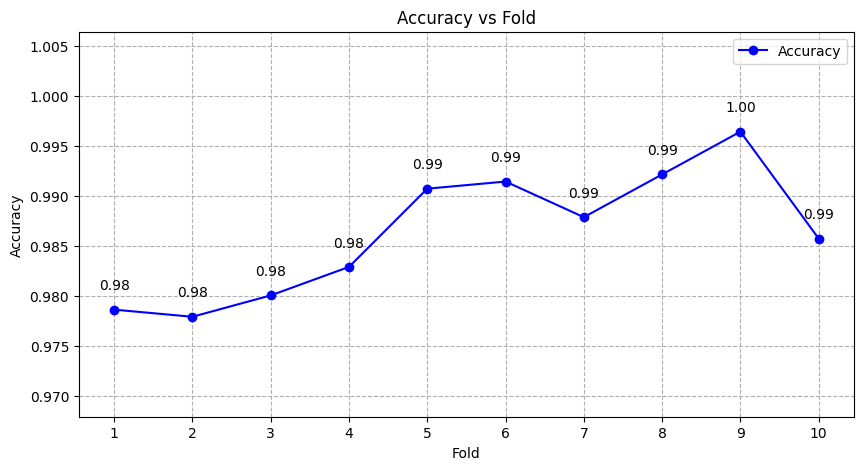

In [ ]:
epochs = list(range(1, len(cnn_model_fold_accuracies) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, cnn_model_fold_accuracies, marker='o', linestyle='-', color='b', label="Accuracy")

for i, acc in enumerate(cnn_model_fold_accuracies):
    plt.text(epochs[i], cnn_model_fold_accuracies[i] + 0.002, f"{acc:.2f}", ha='center', fontsize=10, color='black')

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Fold")
plt.xticks(epochs)
plt.ylim(min(cnn_model_fold_accuracies) - 0.01, max(cnn_model_fold_accuracies) + 0.01)
plt.legend()
plt.grid(True, linestyle = "--")
plt.show()

In [ ]:
# function to plot Train vs Test metrics (Accuracy/Loss)
def plot_metric(train_metric, test_metric, metric_name):
    epochs = range(1, len(train_metric) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metric, 'bo-', label=f'Train {metric_name}')
    plt.plot(epochs, test_metric, 'ro-', label=f'Test {metric_name}')

    for i, txt in enumerate(train_metric):
        plt.annotate(f"{txt:.2f}", (epochs[i], train_metric[i]), textcoords="offset points", xytext=(0,5), ha='center')

    for i, txt in enumerate(test_metric):
        plt.annotate(f"{txt:.2f}", (epochs[i], test_metric[i]), textcoords="offset points", xytext=(0,5), ha='center')

    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'Train vs Test {metric_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

def get_metrics(dataset, model):
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataset:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return precision, recall, f1,all_labels, all_preds

def get_classification_report(labels, predictions, target_classes):
    return classification_report(labels, predictions, target_names = target_classes)

def print_confusion_matrix_heatmap(labels, pred):
    conf_matrix = confusion_matrix(labels, pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_loader.dataset.classes,
                yticklabels=test_loader.dataset.classes)
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

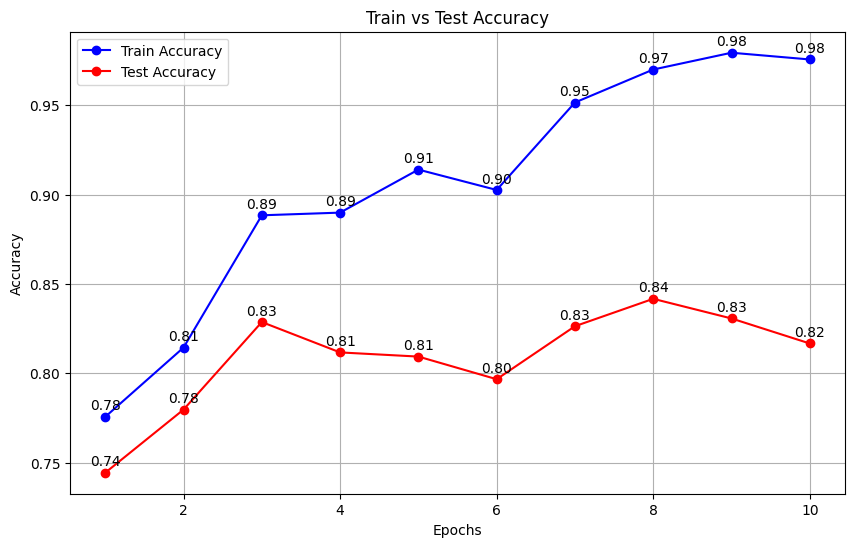

In [ ]:
plot_metric(cnn_train_accuracy, cnn_test_accuracy, "Accuracy")

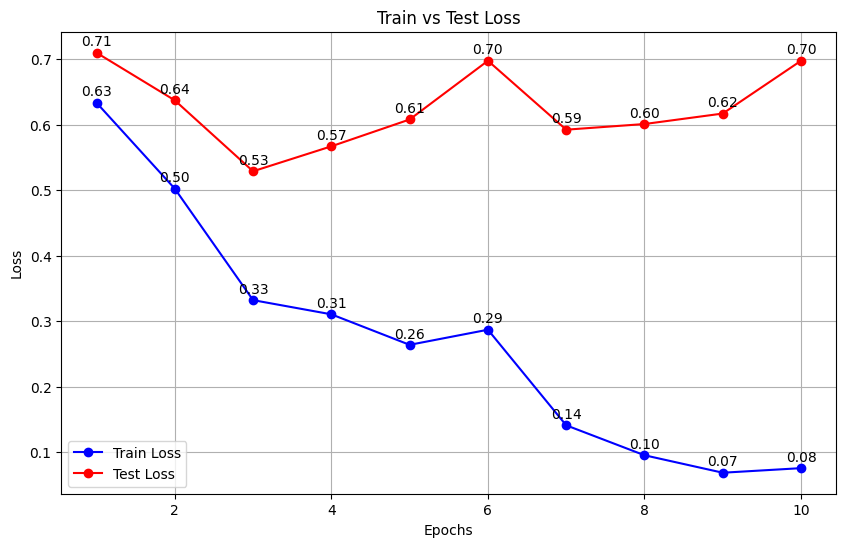

In [ ]:
plot_metric(cnn_train_loss, cnn_test_loss, "Loss")

In [ ]:
precision, recall, f1,labels, predictions = get_metrics(test_loader,cnn_model)

Precision: 0.8341
Recall: 0.8315
F1 Score: 0.8309


In [ ]:
report = get_classification_report(labels, predictions, test_loader.dataset.classes)
print(report)

              precision    recall  f1-score   support

   buildings       0.84      0.77      0.81       437
      forest       0.95      0.96      0.96       474
     glacier       0.79      0.78      0.78       553
    mountain       0.81      0.72      0.76       525
         sea       0.76      0.91      0.83       510
      street       0.85      0.84      0.85       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



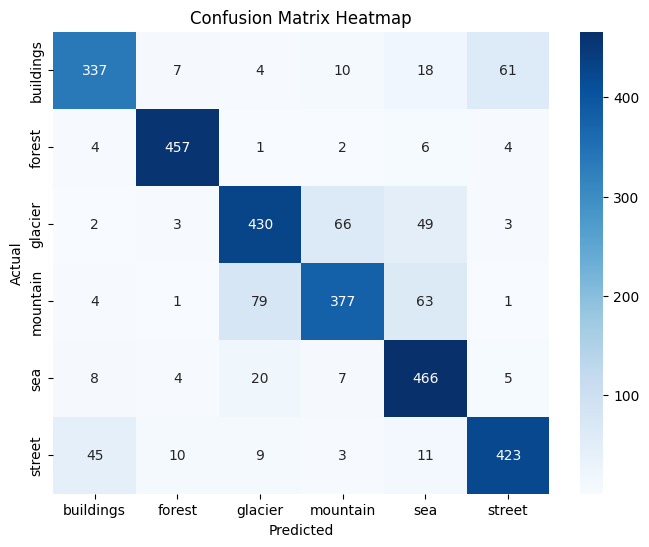

In [ ]:
print_confusion_matrix_heatmap(labels, predictions)

## Experimentation

### ResNet - 18 Pretrained Model

In [ ]:
model_resnet = models.resnet18(pretrained = True)
total_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(total_features, 6)
model_resnet = model_resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


In [ ]:
summary(model_resnet, input_size=(3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

In [ ]:
resnet18_loss_function = nn.CrossEntropyLoss()
resnet18_optimizer = optim.Adam(model_resnet.parameters() , lr = 0.001)
resnet18_train_loss, resnet18_train_accuracy, resnet18_test_loss, resnet18_test_accuracy = build_model(train_loader, test_loader, model_resnet, resnet18_loss_function, resnet18_optimizer, EPOCHS, "ResNet-18 Pretrained")

Training ResNet-18 Pretrained model...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
loss: 2.15976  [32/14034]
loss: 0.43439  [1632/14034]
loss: 0.39654  [3232/14034]
loss: 0.30229  [4832/14034]
loss: 0.55859  [6432/14034]
loss: 0.32479  [8032/14034]
loss: 0.50402  [9632/14034]
loss: 0.32542  [11232/14034]
loss: 0.20009  [12832/14034]

Train Analysis: 
 Accuracy: 90.1%, Avg loss: 0.29336 

Test Analysis: 
 Accuracy: 87.4%, Avg loss: 0.35704 

Epoch 2/10
loss: 0.28953  [32/14034]
loss: 0.58020  [1632/14034]
loss: 0.73488  [3232/14034]
loss: 0.30148  [4832/14034]
loss: 0.24745  [6432/14034]
loss: 0.11370  [8032/14034]
loss: 0.18263  [9632/14034]
loss: 0.52986  [11232/14034]
loss: 0.38946  [12832/14034]

Train Analysis: 
 Accuracy: 87.5%, Avg loss: 0.38009 

Test Analysis: 
 Accuracy: 85.5%, Avg loss: 0.44301 

Epoch 3/10
loss: 0.26689  [32/14034]
loss: 0.36348  [1632/14034]
loss: 0.25562  [3232/14034]
loss: 0.22859  [4832/14034]
loss: 0.10087  [6432/14034]
loss: 0.30520  [8032/14034]
loss: 0.23693  [9632/14034]
loss: 0.58376  [11232/14034]
loss: 0.31582  [1283

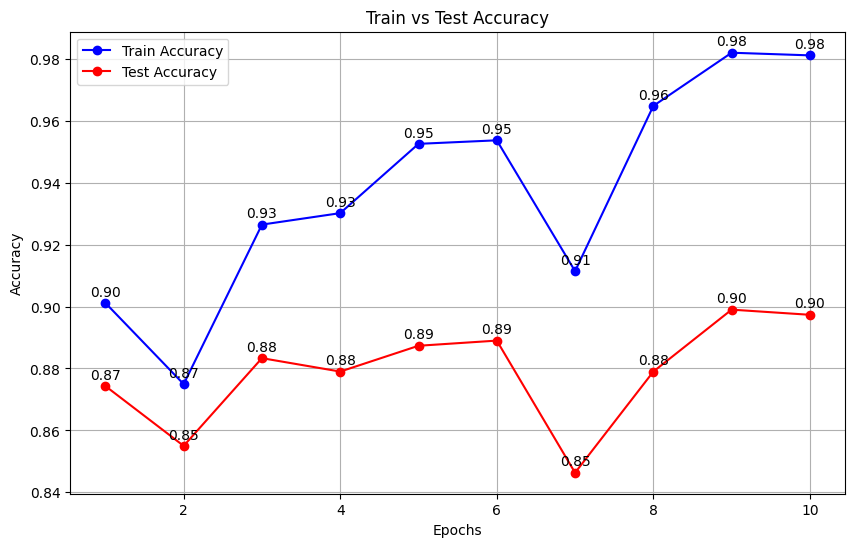

In [ ]:
plot_metric(resnet18_train_accuracy, resnet18_test_accuracy, "Accuracy")

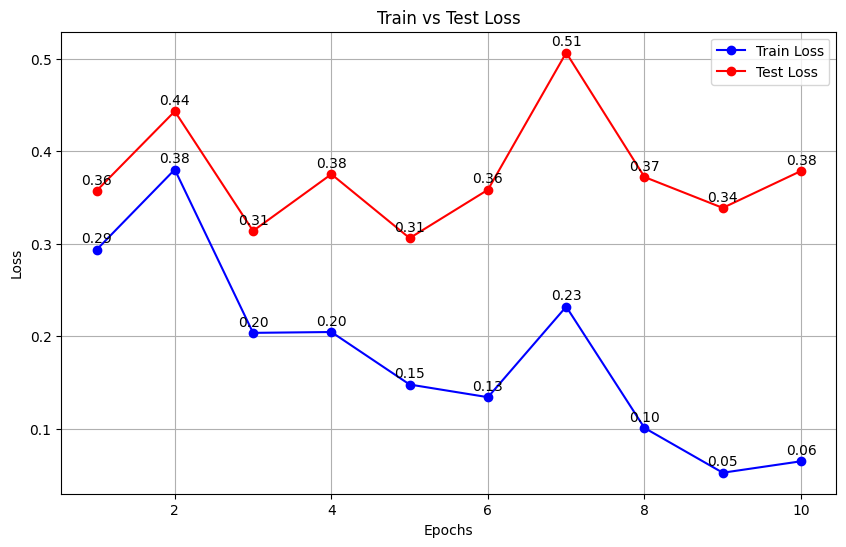

In [ ]:
plot_metric(resnet18_train_loss, resnet18_test_loss, "Loss")

In [ ]:
resnet18_precision, resnet18_recall, resnet18_f1, resnet18_labels, resnet18_predictions = get_metrics(test_loader, model_resnet)

Precision: 0.8999
Recall: 0.8998
F1 Score: 0.8995


In [ ]:
resnet18_report = get_classification_report(resnet18_labels, resnet18_predictions, test_loader.dataset.classes)
print(resnet18_report)

              precision    recall  f1-score   support

   buildings       0.87      0.93      0.90       437
      forest       0.98      0.94      0.96       474
     glacier       0.83      0.83      0.83       553
    mountain       0.85      0.86      0.86       525
         sea       0.94      0.94      0.94       510
      street       0.93      0.89      0.91       501

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



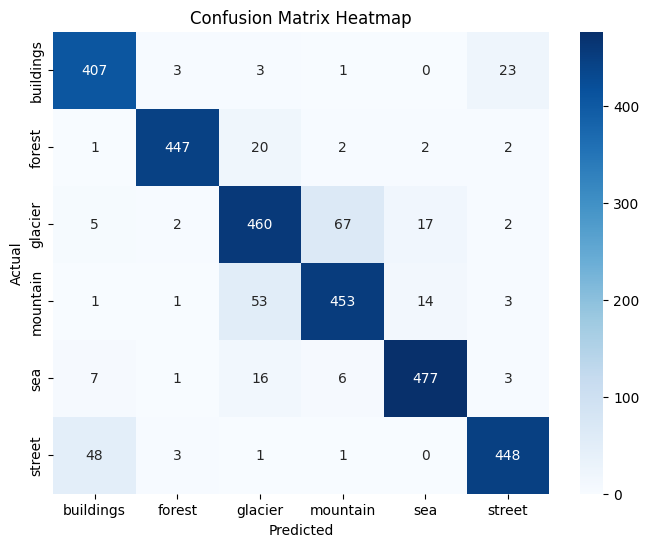

In [ ]:
print_confusion_matrix_heatmap(resnet18_labels, resnet18_predictions)

### ResNet - 18 With Freezed layers

In [ ]:
model_conv = models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

total_features = model_conv.fc.in_features
model_conv.fc = nn.Linear(total_features, 6)
model_conv = model_conv.to(device)

In [ ]:
summary(model_conv, input_size=(3, IMG_SIZE, IMG_SIZE))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 75, 75]           9,408
       BatchNorm2d-2           [-1, 64, 75, 75]             128
              ReLU-3           [-1, 64, 75, 75]               0
         MaxPool2d-4           [-1, 64, 38, 38]               0
            Conv2d-5           [-1, 64, 38, 38]          36,864
       BatchNorm2d-6           [-1, 64, 38, 38]             128
              ReLU-7           [-1, 64, 38, 38]               0
            Conv2d-8           [-1, 64, 38, 38]          36,864
       BatchNorm2d-9           [-1, 64, 38, 38]             128
             ReLU-10           [-1, 64, 38, 38]               0
       BasicBlock-11           [-1, 64, 38, 38]               0
           Conv2d-12           [-1, 64, 38, 38]          36,864
      BatchNorm2d-13           [-1, 64, 38, 38]             128
             ReLU-14           [-1, 64,

In [ ]:
model_conv_loss_function = nn.CrossEntropyLoss()
model_conv_optimizer = optim.Adam(model_conv.fc.parameters() , lr = 0.001)
model_conv_train_loss, model_conv_train_accuracy, model_conv_test_loss, model_conv_test_accuracy = build_model(train_loader, test_loader,  model_conv, model_conv_loss_function, model_conv_optimizer, EPOCHS, "ResNet-18 Pretrained with Freezed layers")

Training ResNet-18 Pretrained with Freezed layers model...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
loss: 2.16644  [32/14034]
loss: 0.75338  [1632/14034]
loss: 0.57715  [3232/14034]
loss: 0.57005  [4832/14034]
loss: 0.32411  [6432/14034]
loss: 0.24465  [8032/14034]
loss: 0.40819  [9632/14034]
loss: 0.33268  [11232/14034]
loss: 0.55366  [12832/14034]

Train Analysis: 
 Accuracy: 88.9%, Avg loss: 0.32286 

Test Analysis: 
 Accuracy: 89.0%, Avg loss: 0.33913 

Epoch 2/10
loss: 0.37974  [32/14034]
loss: 0.40964  [1632/14034]
loss: 0.57982  [3232/14034]
loss: 0.29310  [4832/14034]
loss: 0.41824  [6432/14034]
loss: 0.21159  [8032/14034]
loss: 0.34955  [9632/14034]
loss: 0.48749  [11232/14034]
loss: 0.31315  [12832/14034]

Train Analysis: 
 Accuracy: 89.3%, Avg loss: 0.29900 

Test Analysis: 
 Accuracy: 88.6%, Avg loss: 0.32261 

Epoch 3/10
loss: 0.16788  [32/14034]
loss: 0.24660  [1632/14034]
loss: 0.40655  [3232/14034]
loss: 0.62752  [4832/14034]
loss: 0.45692  [6432/14034]
loss: 0.23786  [8032/14034]
loss: 0.41106  [9632/14034]
loss: 0.29364  [11232/14034]
loss: 0.16232  [1283

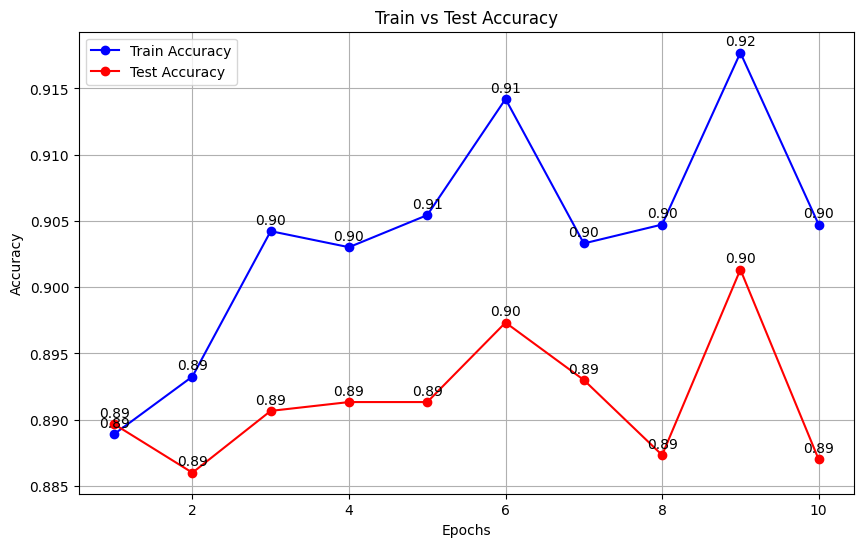

In [ ]:
plot_metric(model_conv_train_accuracy, model_conv_test_accuracy, "Accuracy")

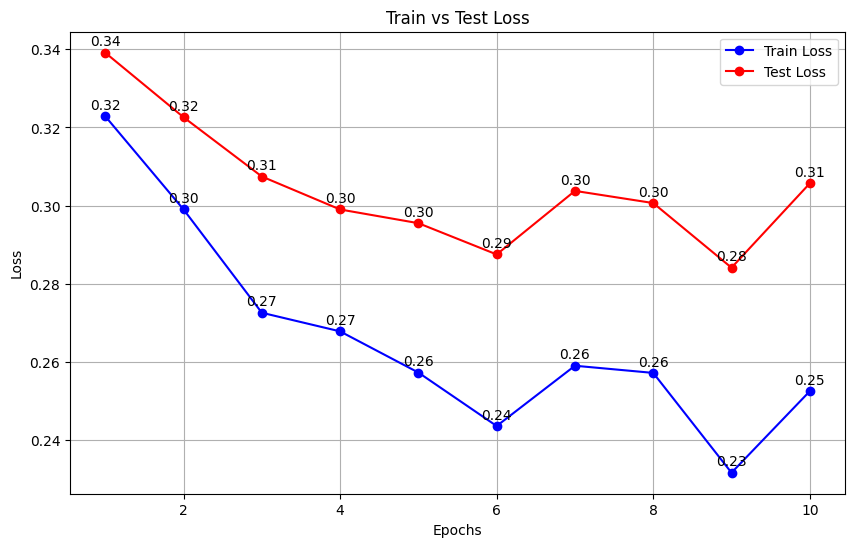

In [ ]:
plot_metric(model_conv_train_loss, model_conv_test_loss, "Loss")

In [ ]:
model_conv_precision, model_conv_recall, model_conv_f1, model_conv_labels, model_conv_predictions = get_metrics(test_loader, model_conv)

Precision: 0.8933
Recall: 0.8902
F1 Score: 0.8893


In [ ]:
model_conv_report = get_classification_report(model_conv_labels, model_conv_predictions, test_loader.dataset.classes)
print(model_conv_report)

              precision    recall  f1-score   support

   buildings       0.85      0.94      0.90       437
      forest       0.98      0.98      0.98       474
     glacier       0.77      0.88      0.82       553
    mountain       0.88      0.74      0.80       525
         sea       0.92      0.94      0.93       510
      street       0.95      0.86      0.90       501

    accuracy                           0.89      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.89      0.89      0.89      3000



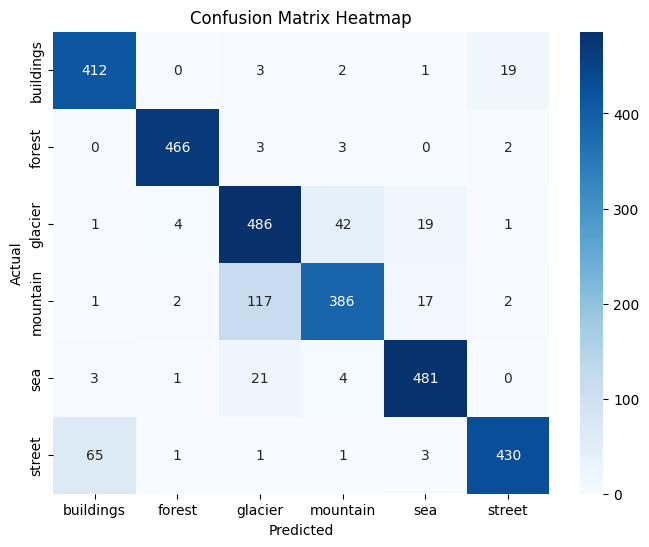

In [ ]:
print_confusion_matrix_heatmap(model_conv_labels, model_conv_predictions)

### Tweaking the CNN Model
Changing the optimizer to SGD

In [ ]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)
cnn_sgd_train_loss, cnn_sgd_train_accuracy, cnn_sgd_test_loss, cnn_sgd_test_accuracy = build_model(train_loader, test_loader, cnn_model, loss_function, optimizer, EPOCHS, "CNN")

Training CNN model...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
loss: 0.71131  [32/14034]
loss: 1.11300  [1632/14034]
loss: 0.45700  [3232/14034]
loss: 0.13868  [4832/14034]
loss: 0.64163  [6432/14034]
loss: 0.25062  [8032/14034]
loss: 0.11613  [9632/14034]
loss: 0.48340  [11232/14034]
loss: 0.70483  [12832/14034]

Train Analysis: 
 Accuracy: 96.9%, Avg loss: 0.09752 

Test Analysis: 
 Accuracy: 79.7%, Avg loss: 1.37520 

Epoch 2/10
loss: 0.34578  [32/14034]
loss: 0.26875  [1632/14034]
loss: 0.74537  [3232/14034]
loss: 0.42239  [4832/14034]
loss: 0.14555  [6432/14034]
loss: 0.38879  [8032/14034]
loss: 0.30909  [9632/14034]
loss: 0.42663  [11232/14034]
loss: 1.73299  [12832/14034]

Train Analysis: 
 Accuracy: 90.3%, Avg loss: 0.28866 

Test Analysis: 
 Accuracy: 72.4%, Avg loss: 1.14718 

Epoch 3/10
loss: 0.76858  [32/14034]
loss: 0.16838  [1632/14034]
loss: 0.50879  [3232/14034]
loss: 0.92759  [4832/14034]
loss: 1.94599  [6432/14034]
loss: 0.17653  [8032/14034]
loss: 0.04867  [9632/14034]
loss: 0.80447  [11232/14034]
loss: 1.44815  [1283

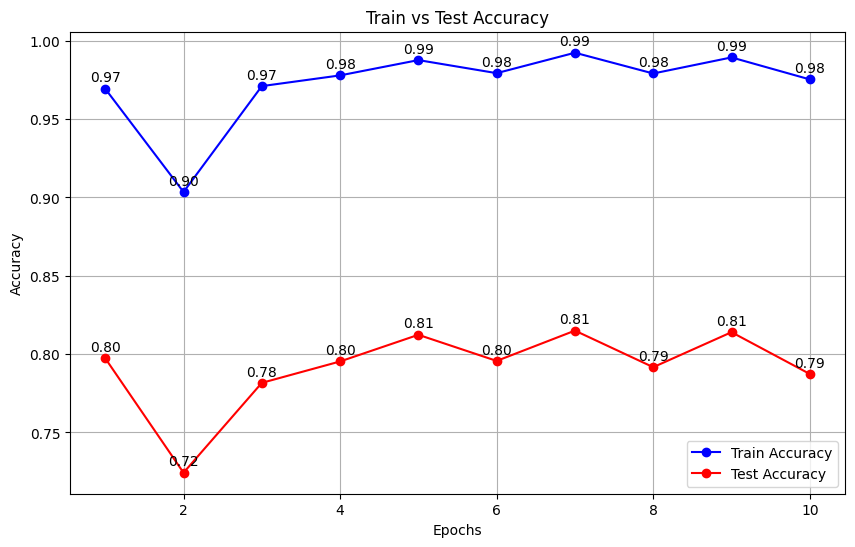

In [ ]:
plot_metric(cnn_sgd_train_accuracy, cnn_sgd_test_accuracy, "Accuracy")

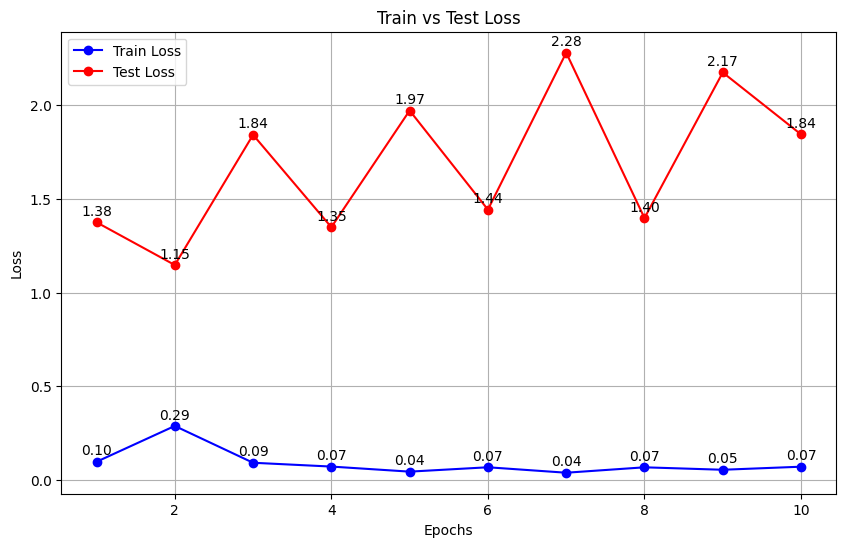

In [ ]:
plot_metric(cnn_sgd_train_loss, cnn_sgd_test_loss, "Loss")

In [ ]:
precision, recall, f1,labels, predictions = get_metrics(test_loader,cnn_model)

Precision: 0.8008
Recall: 0.7870
F1 Score: 0.7906


In [ ]:
report = get_classification_report(labels, predictions, test_loader.dataset.classes)
print(report)

              precision    recall  f1-score   support

   buildings       0.84      0.71      0.77       437
      forest       0.97      0.92      0.94       474
     glacier       0.72      0.80      0.76       553
    mountain       0.66      0.80      0.72       525
         sea       0.80      0.67      0.73       510
      street       0.82      0.82      0.82       501

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.79      0.79      3000



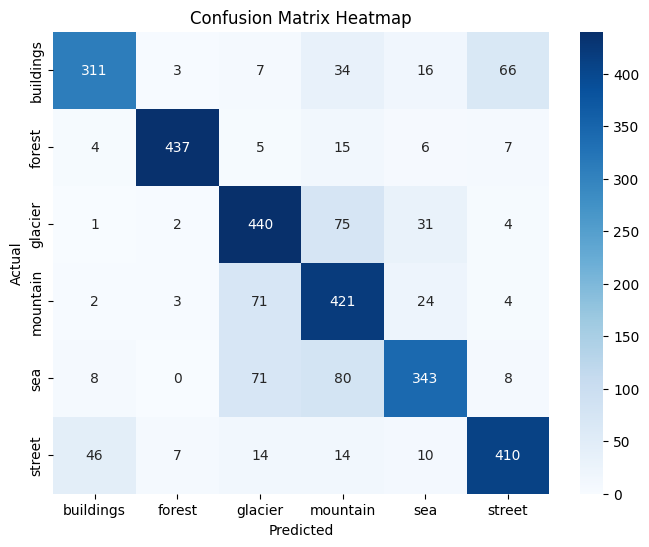

In [ ]:
print_confusion_matrix_heatmap(labels, predictions)

## Comparison between Models

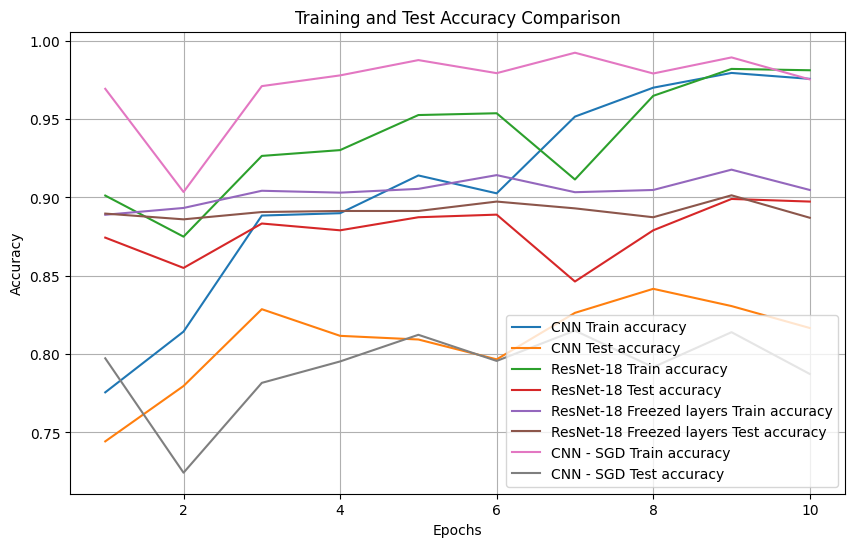

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting training and test accuracy for each model
plt.plot(epochs, cnn_train_accuracy, label='CNN Train accuracy')
plt.plot(epochs, cnn_test_accuracy, label='CNN Test accuracy')
plt.plot(epochs, resnet18_train_accuracy, label='ResNet-18 Train accuracy')
plt.plot(epochs, resnet18_test_accuracy, label='ResNet-18 Test accuracy')
plt.plot(epochs, model_conv_train_accuracy, label='ResNet-18 Freezed layers Train accuracy')
plt.plot(epochs, model_conv_test_accuracy, label='ResNet-18 Freezed layers Test accuracy')
plt.plot(epochs, cnn_sgd_train_accuracy, label='CNN - SGD Train accuracy')
plt.plot(epochs, cnn_sgd_test_accuracy, label='CNN - SGD Test accuracy')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Comparison')

# Displaying the legend
plt.legend()

plt.grid(True)
plt.show()